# Clustering and Partitioning Nodes in Graphs

In [142]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
import slideUtilities as sl
print('')

In [143]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

Today we'll return to the subject of clustering, but now we'll be looking at nodes of a graph.

Why might we want to cluster graph nodes?

* If graph nodes are our "data objects", then we might want to cluster them for all of the same reasons as we did for the case when data objects were simple records or tuples.
* Even for simple records, a distance matrix can be interpreted as a weighted graph.
* In social networks, we may want to identify communities.
* In the Web, we may want to find groups of related pages.

Outline:
    
1. k-core decomposition
2. Min s-t cut
3. Min cut
4. Spectral graph partitioning

## K-core Decomposition

The idea behind k-core decomposition is to find a subset of a graph that represents its "core."

These are considered to be well-connected nodes that form a subgraph.

The subgraph may or may not be connected, but usually it is.

To capture this ideal formally, we say that the __k-core__ of $G = (V,E)$ is a __subgraph__ $G_k$ of $G$ such that all nodes in $G_k$ have degree at least $k$.

The code number of a node $n$ is $c(n)$ if $n$ is contained in the $c(n)$ core but not in the $c(n) + 1$ core.

The set of all $k$-cores of a graph is its __$k$-core decomposition.__

In practice, there is a simple, intuitive way to compute the $k$ core decomposition of a graph.

Start with a graph $G$ whose maximum degree is $m$.

``
for n in range(1,m):
    remove all nodes of degree n
        repeat above step until node nodes of degree n are left
    all nodes removed form the n-core
    ``

In [144]:
G=nx.karate_club_graph()
G = nx.Graph(G)
np.random.seed(2)
pos = nx.spring_layout(G)
print('G has {} nodes and maximum degree {}'.format(len(G), max(nx.degree(G).values())))

G has 34 nodes and maximum degree 17


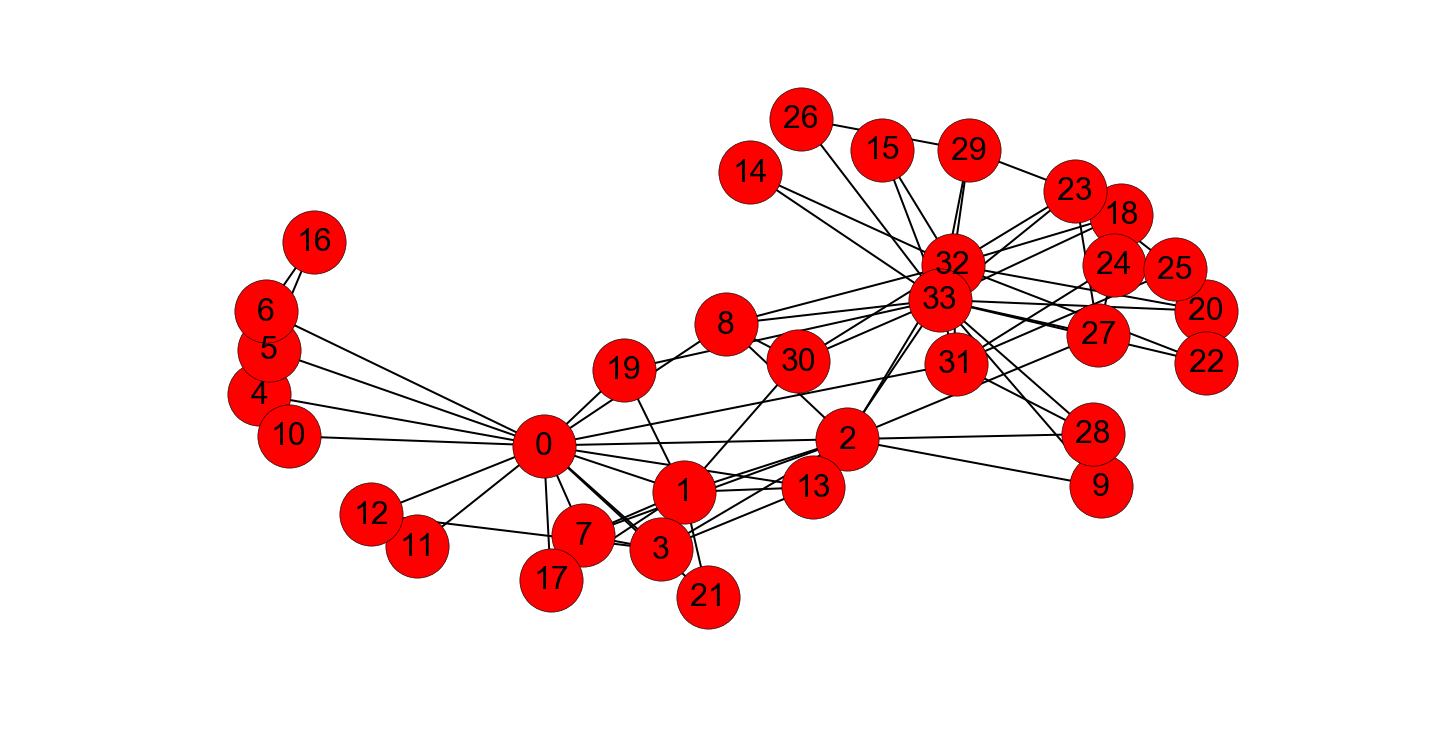

In [145]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
nx.draw(G, pos=pos, with_labels=True, node_size=1000, font_size=16, ax=ax)

Let's compute its $k$-core decomposition.

In [146]:
core_dec = nx.core_number(G)
core_dec

{0: 4,
 1: 4,
 2: 4,
 3: 4,
 4: 3,
 5: 3,
 6: 3,
 7: 4,
 8: 4,
 9: 2,
 10: 3,
 11: 1,
 12: 2,
 13: 4,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 3,
 20: 2,
 21: 2,
 22: 2,
 23: 3,
 24: 3,
 25: 3,
 26: 2,
 27: 3,
 28: 3,
 29: 3,
 30: 4,
 31: 3,
 32: 4,
 33: 4}

Plotting the graph; nodes with the same color belong in the same core

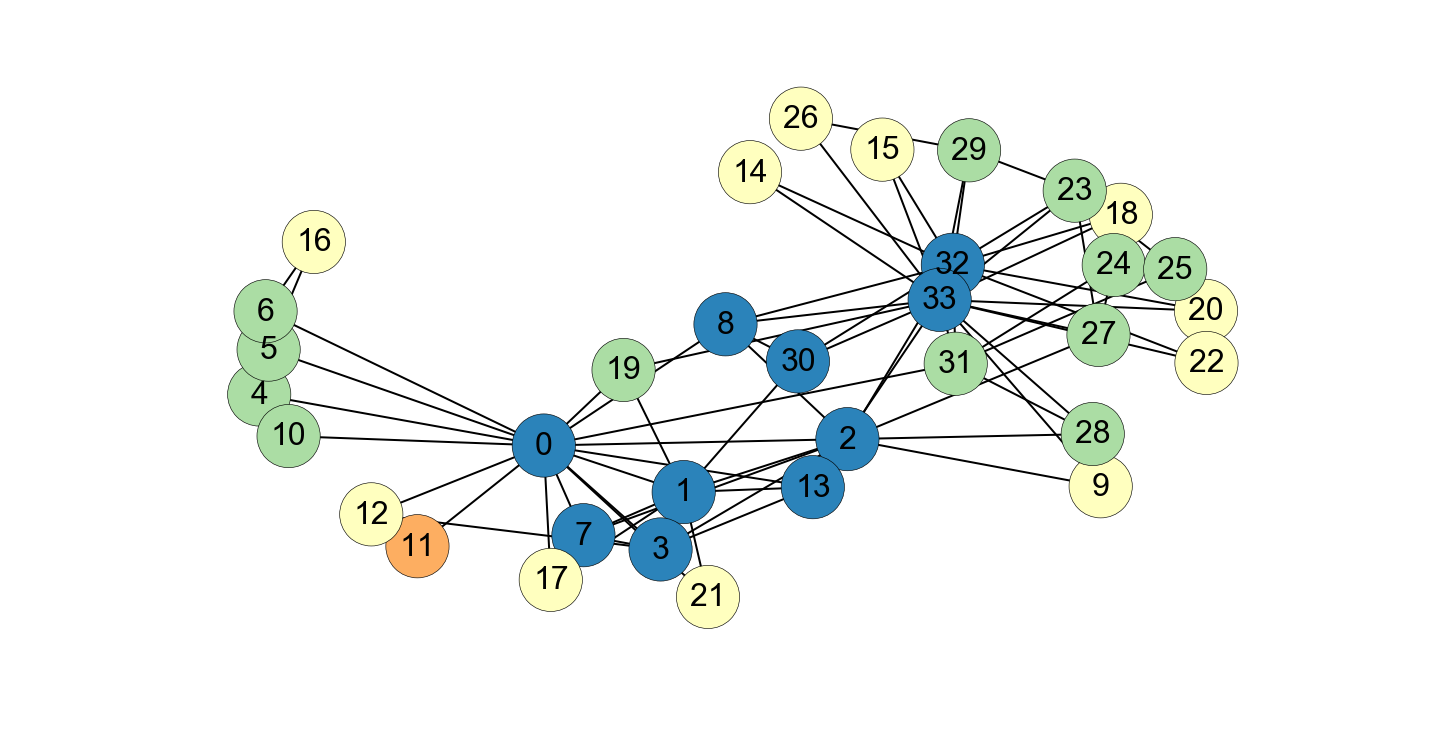

In [147]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
colors = ['#d7191c', '#fdae61', '#ffffbf', '#abdda4', '#2b83ba']
node_colors = [ colors[core_dec[v]] for v in G.nodes()]
nx.draw(G, pos = pos, node_color=node_colors, with_labels=True, node_size=1000, font_size=16, ax=ax)


## Min $s$-$t$ cut

Let us say we have a graph $G$ and two nodes in mind, $s$ and $t$.  

We would like to isolate $s$ from $t$.  What is the cheapest way to do it?

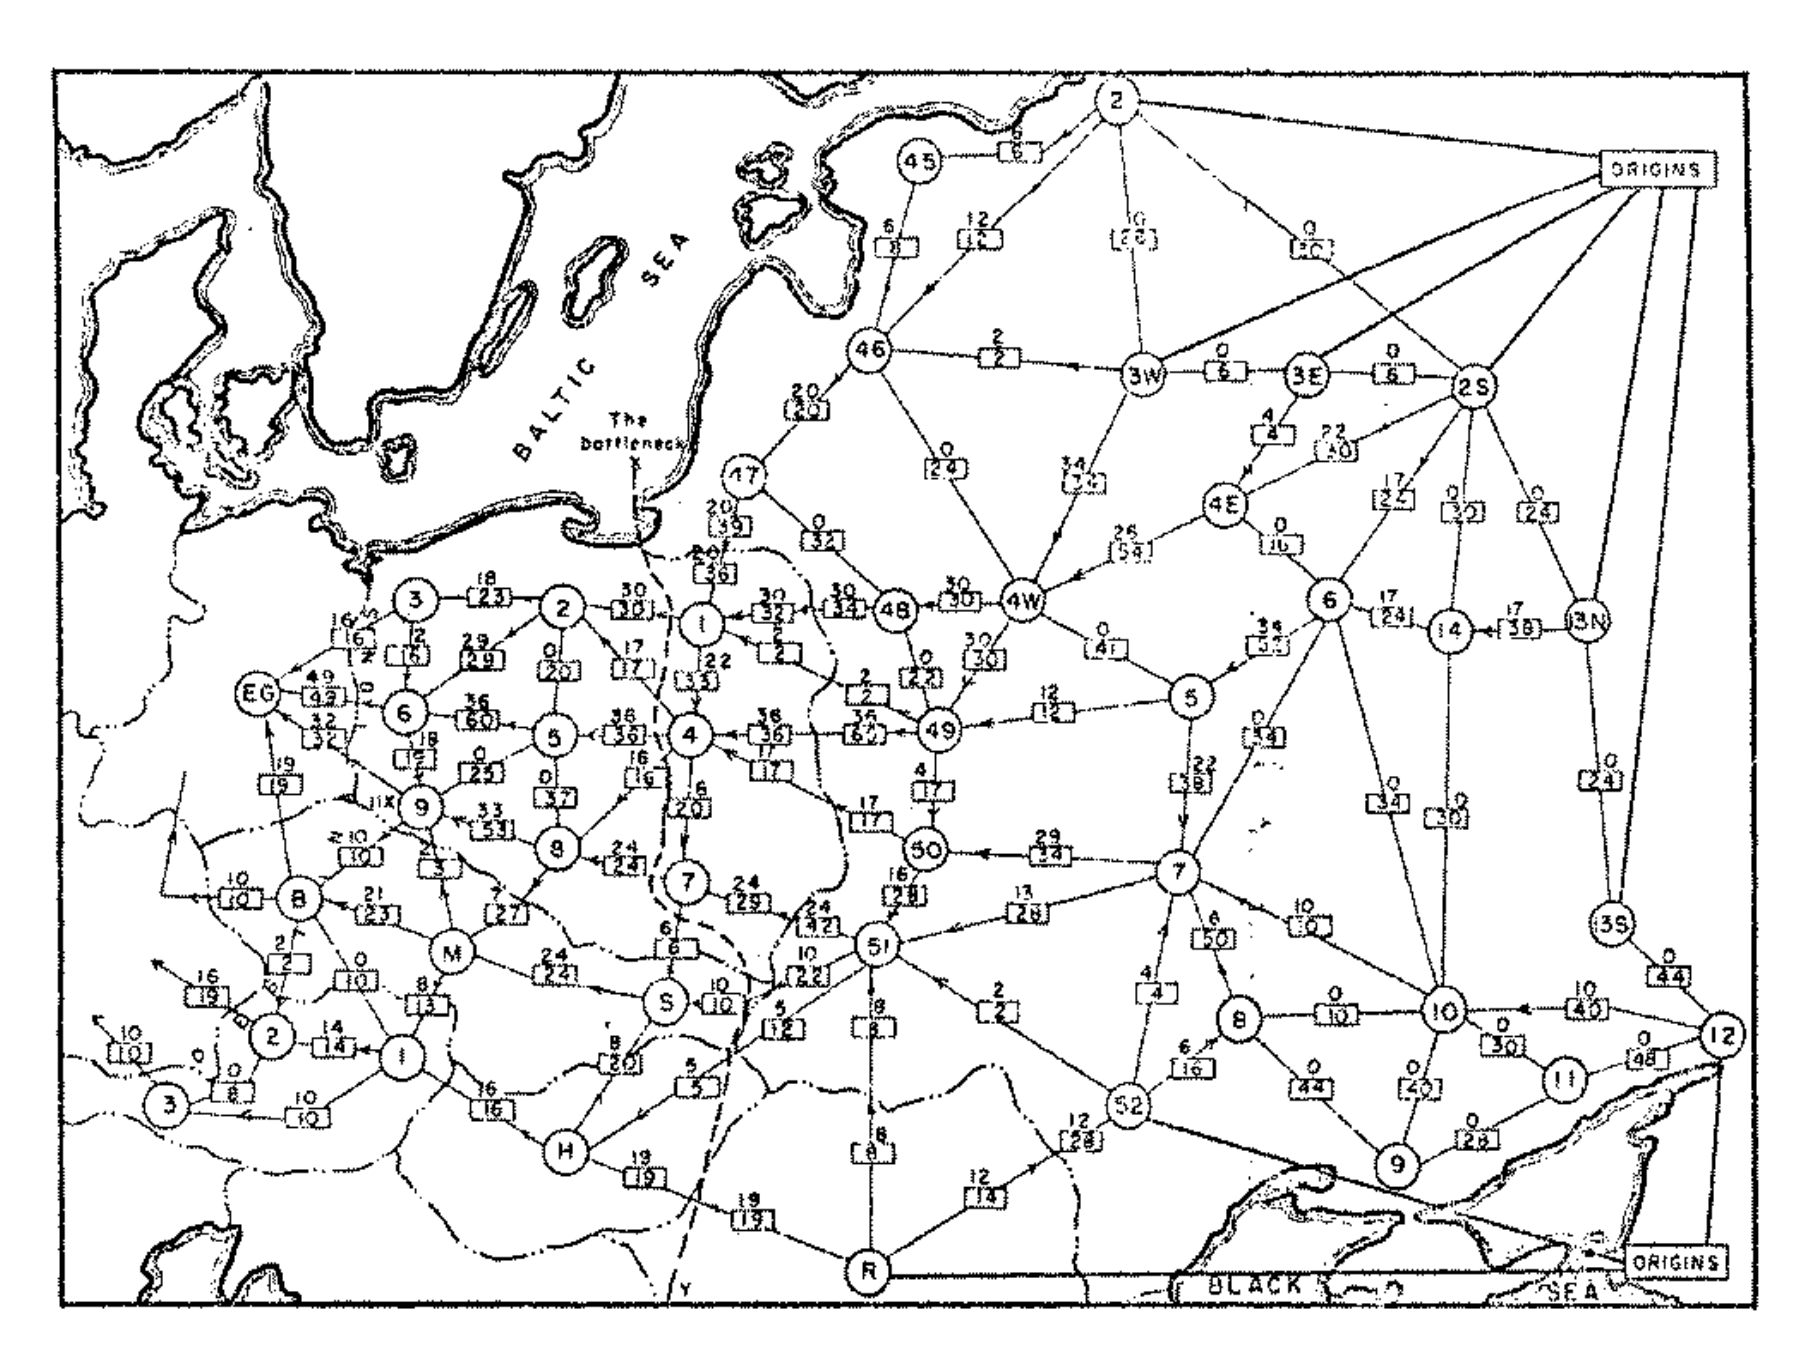

In [148]:
# Image credit: On the history of the transportation and maximum flow problems.
# Alexander Schrijver in Math Programming, 91: 3, 2002.
sl.hide_code_in_slideshow()
display(Image("figs/L23-max-flow-soviet-rail-1955.png", width=600))

A min $s$-$t$ cut problem is as follows.

We are given a weighted graph $G = (V,E)$.

An $s$-$t$ cut $C$ of $G$ is a partition of $V$ into $(U, V-U)$ such that $s \in U$ and $t \in V-U$.

The __cost__ of a cut is the total weight of the edges that go between the two parts:

$$ \text{Cost}(C) = \sum_{e(u,v), u\in U, v\in V-U} w(e)$$

This is a very famous problem that can be solved in time that is polynomial in $|V|$ and $|E|$. Increasingly better solutions have been found over the past 60+ years.  

Looking at the karate club, the two key members are numbers 0 and 33.

In [149]:
cut_edges = nx.minimum_edge_cut(G, s=0, t=33)
cut_edges

{(0, 8),
 (0, 31),
 (1, 30),
 (2, 8),
 (2, 27),
 (2, 28),
 (2, 32),
 (9, 33),
 (13, 33),
 (19, 33)}

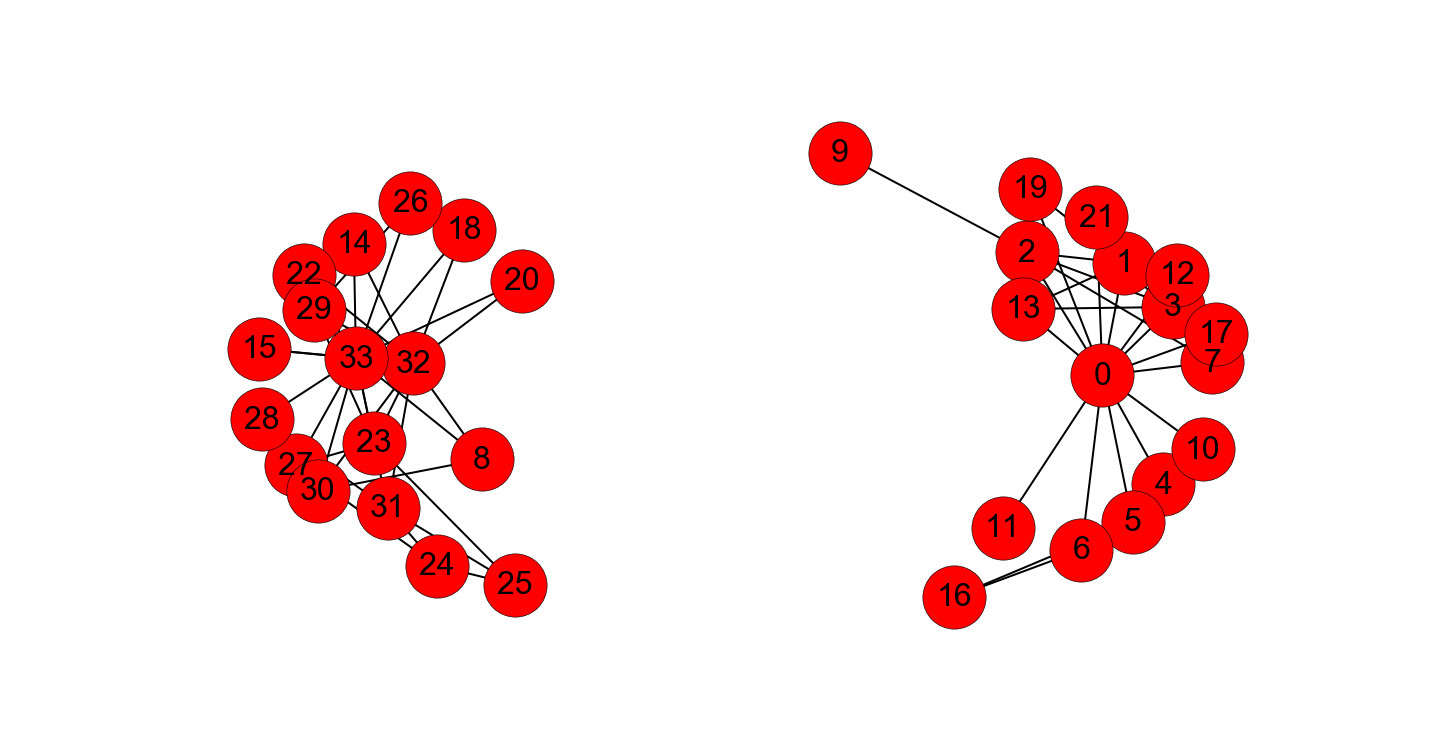

In [150]:
Gcopy = G.copy()
Gcopy.remove_edges_from(cut_edges)
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
nx.draw(Gcopy, with_labels='True', node_size=1000, font_size=16, ax=ax)

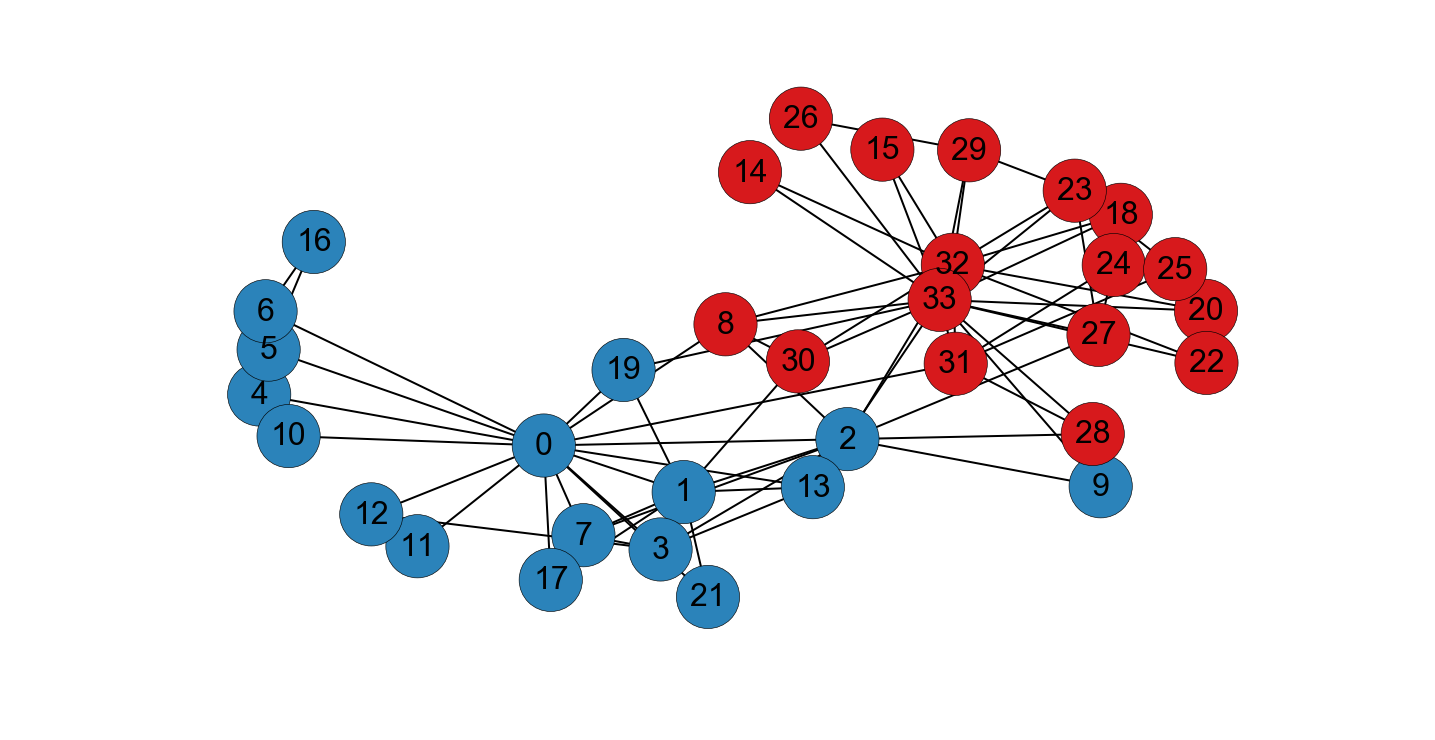

In [151]:
cc = nx.connected_components(Gcopy)
node_set = {node: i for i, s in enumerate(cc) for node in s}
colors = ['#d7191c', '#2b83ba']
node_colors = [ colors[node_set[v]-1] for v in G.nodes()]
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
nx.draw(G, node_color=node_colors, pos=pos, with_labels='True', node_size=1000, font_size=16, ax=ax)

In fact, when Wayne Zachary studied the club, a conflict arose between the instructor and the president (nodes 0 and 33).  Zachary predicted the way the club would split based on an $s$-$t$ min cut.   In fact, he predicted every single member's eventual association accurately except for node 8!

## Minimum Cuts

Now, in partitioning a graph, we may not have any particular $s$ and $t$ in mind.  

Rather, we may want to simply find the "cheapest" way to disconnect the graph.

Clearly, we can do this using $s$-$t$ min cut, by simply trying all $s$ and $t$ pairs.

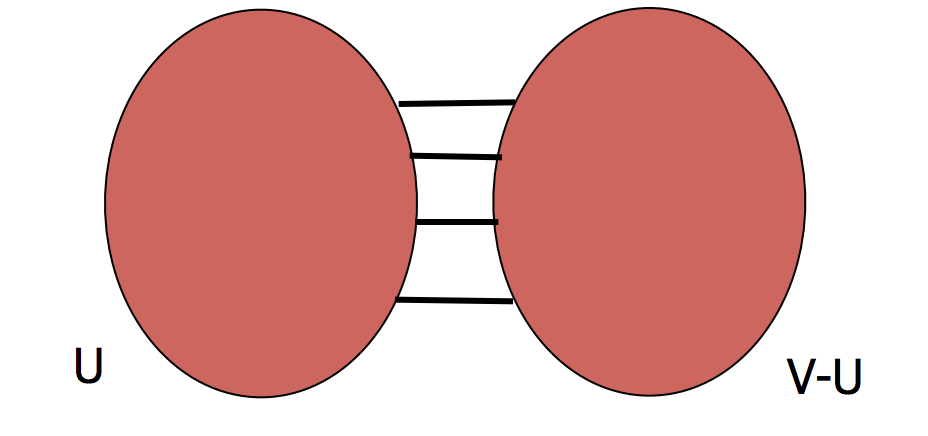

In [152]:
sl.hide_code_in_slideshow()
display(Image("figs/L23-min-cut.png", width=400))

In [153]:
Gcopy = G.copy()
Gcopy.remove_edges_from(nx.minimum_edge_cut(G))
cc = nx.connected_components(Gcopy)
node_set = {node: i for i, s in enumerate(cc) for node in s}

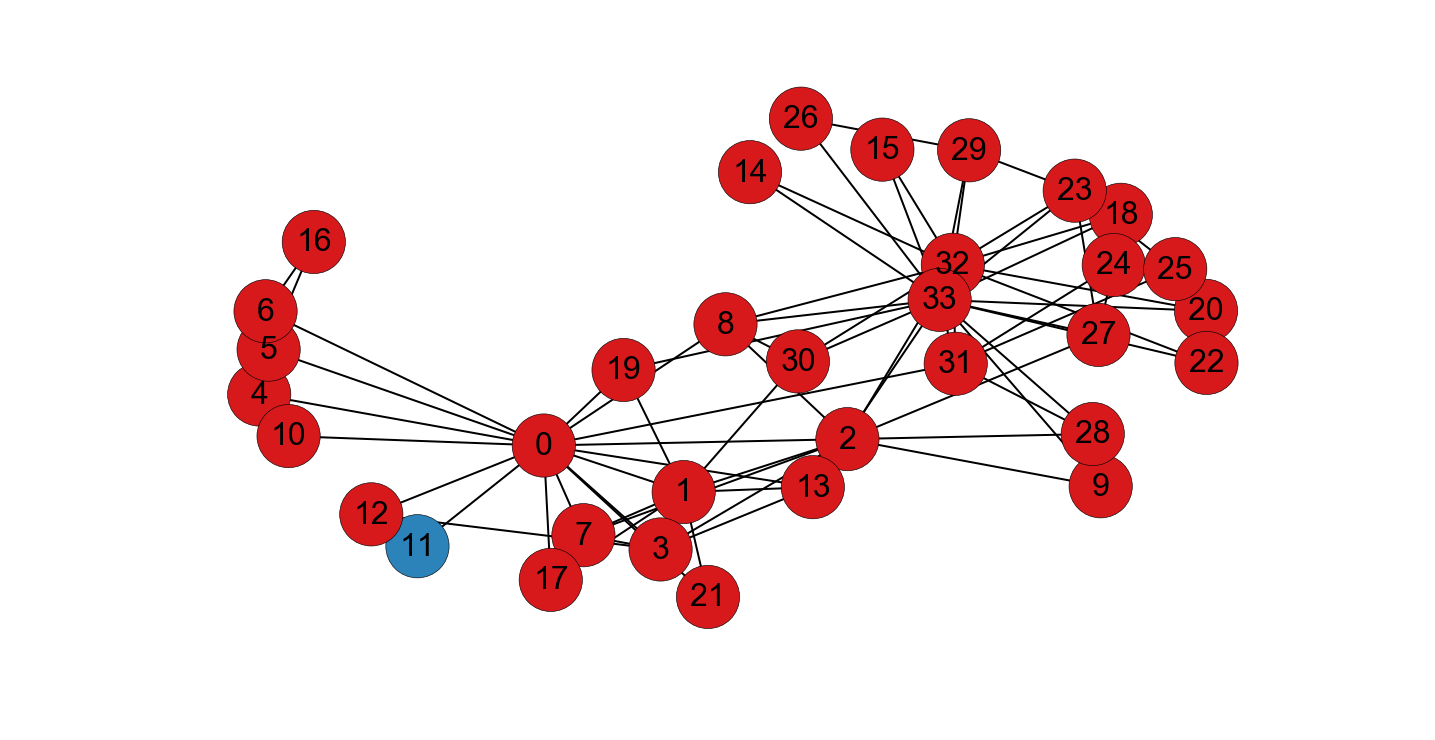

In [154]:
colors = ['#d7191c', '#2b83ba']
node_colors = [colors[node_set[v]] for v in G]
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
nx.draw(G, node_color=node_colors, pos=pos, with_labels='True', node_size=1000, font_size=16, ax=ax)

This is in fact the minimum cut, but it is not a good approach for clustering -- we need to adjust our definition.

__Graph Expansion.__

The idea to avoid the problem above is to normalize the cut by the size of the smaller of the two components.

The problem above would be avoided because the smaller of the two cuts is just a single node.

This leads us to define the __isoperimetric ratio__:
    
$$ \alpha = \frac{E(U, V\setminus U)}{\min(|U|, |V\setminus U|)} $$

And the __isoperimetric number of G:__
    
$$ \alpha(G) = \min_U \frac{E(U, V\setminus U)}{\min(|U|, |V\setminus U|)} $$

The idea is that finding $\alpha(G)$ gives a _balanced cut_ -- one that maximizes the number of disconnected nodes per edge removed.

How easily can we compute this?  

Unfortunately, it's not computable in polynomial time.

However, we can make good approximations, which we'll look at now.

For every $U \subset V$, $\alpha(G) \geq \lambda_2 (1-s)$ where $s = |U|/|V|$.

## Graph spectral analysis

To study approximations to balanced cuts, we introduce some terms.

For a graph $G$ with adjacency matrix $A$, we define the graph __Laplacian__ as:

$$ L = D - A $$

where $D$ is a diagonal matrix with node degrees on the diagonal.

I.e., $D = \text{diag}(d_1, d_2, d_3, \dots)$ where $d_i$ is the degree of node $i$.

The Laplacian $L$ is symmetric and positive semi-definite.

All eigenvalues of $L$ are real and nonnegative.

$L$ has a single eigenvalue of value $\lambda_1 = 0$.   The corresponding eigenvector is $w_1 = (1, 1, 1, \dots)^T$.

This is easily seen:

$$L{\mathbf 1}={\mathbf 0}.$$

An important fact about the Laplacian is this:
    
The quadratic form

$$ x^TLx$$

is exactly the same as

$$  \sum_{(i,j)\in E} (x_i - x_j)^2 $$

The second-smallest eigenvalue of $L$ is $\lambda_2$, called the __Fiedler value.__

We know that all of the other eigenvectors of $L$ are orthogonal to $\mathbf 1$, because $L$ is symmetric.

So $$\lambda_2 = \min_{\Vert x\Vert = 1, x\perp {\mathbf 1}} x^TLx$$

Note that another way of saying that $x \perp {\mathbf 1}$ is that the entries of $x$ sum to 0.

The corresponding eigenvector is called the __Fiedler vector.__

It minimizes:

$$\lambda_2 = \min_{\Vert x\Vert=1,x\perp {\mathbf 1}} \sum_{(i,j)\in E} (x_i - x_j)^2$$

Let's look at this closely: 

if we think of $x_i$ as a "coordinate" for node $i$ in the graph, 

then choosing $x = w_2$ (the eigenvector of $\lambda_2$) puts each node in a position that minimizes the sum of the "stretching" of each edge.

This is exactly the "spring" layout that we previously discussed, but in only one dimension.  

Recall that the spring layout was time consuming to compute in multiple dimensions, but it turns out to have this pleasing form in one dimension.

So $w_2$ will group strongly-connected nodes together.

This leads to key ideas in node paritioning.

The basic idea is to partition nodes according to the Fiedler vector ($w_2$).

This can be shown to have provably good performance for the __balanced cut__ problem.

There are a number of options for how to split based on the Fiedler vector.

If $w_2$ is the Fiedler vector, then split nodes according to a value $s$:
    
* bisection: $s$ is the median value in $w_2$
* ratio cut: $s$ is the value that maximizes $\alpha$
* sign: separate positive and negative vaues ($s = 0$)
* gap: separate according to the largest gap in the values of $w_2$

### Spectral Partitioning of the Karate-club Graph

In [155]:
G=nx.karate_club_graph()
G = nx.Graph(G)

In [156]:
f = nx.fiedler_vector(G)
f

array([-0.11213743, -0.04128789,  0.02321895, -0.05549978, -0.28460452,
       -0.32372722, -0.32372722, -0.052586  ,  0.05160127,  0.09280087,
       -0.28460452, -0.21099295, -0.10946129, -0.01474197,  0.16275078,
        0.16275078, -0.42276533, -0.10018142,  0.16275078, -0.01363713,
        0.16275078, -0.10018142,  0.16275078,  0.15569457,  0.15302558,
        0.16096292,  0.18710959,  0.12766405,  0.0951523 ,  0.16765033,
        0.07349963,  0.09875343,  0.13034546,  0.11890326])

In [157]:
s = np.zeros(len(f),dtype='int')
s[f>0]=1
print(s, type(s))

[0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'>


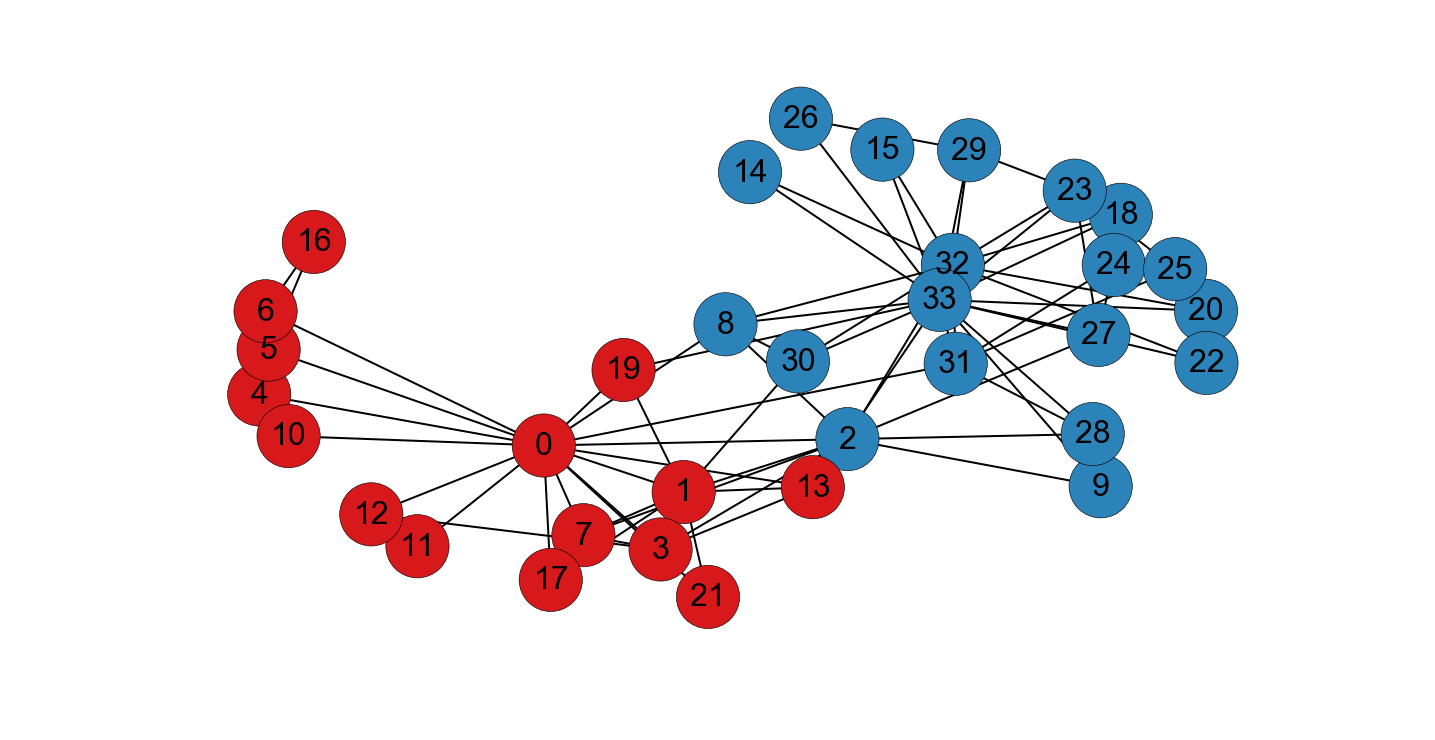

In [158]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
colors = ['#d7191c', '#2b83ba']
node_colors = [colors[s[v]] for v in G]
nx.draw(G, pos=pos, node_color=node_colors, with_labels='True',node_size=1000, font_size=16, ax=ax)

Interestingly, this is almost the same as the $s$-$t$ min cut  based on the president and instructor!

### Exploring  a union of noisy cliques

In [159]:
from numpy.random import RandomState

def generate_noisy_subcliques(nodes_per_clique, inside_p, across_p, min_node_label=0, seed=None):
    """Generates a graph which consists of small cliques connected with each other.
    The noise within a clique and across cliques can be set by the `inside_p` and 
    `across_p` parameters respectively.   This is also called a "stochastic block model."
    
    
    Parameters
    ----------
    nodes_per_clique : list
        The size of this list corresponds to the number of cliques that will be
        generated. The value of each element will be the size of the corresponding 
        clique.
        
    inside_p : float
        The probability of an edge inside a clique. The higher this number, the more 
        each clique will resemble a fully connected graph.
        
    across_p : float
        The probability of an edge across cliques.
        
    min_node_label : int, default is 0
        The minimum node label of the graph.
        
    seed : int, default is None
        The seed to the pseudorandom number generator.
        
    
    Returns
    -------
    G : networkX graph
        The generated graph.
    """

    prng = RandomState(seed)
    clique_list = []
    number_of_cliques = len(nodes_per_clique)

    # Make the independent cliques
    starting_node = min_node_label
    for clique in range(number_of_cliques):
        G = nx.Graph()
        for u in range(starting_node, starting_node + nodes_per_clique[clique]):
            for v in range(u + 1, starting_node + nodes_per_clique[clique]):
                if prng.rand() < inside_p:
                    G.add_edge(u, v)
        clique_list.append(G)
        starting_node += nodes_per_clique[clique]

    # Combine them in one graph
    G = nx.Graph()
    for clique in range(number_of_cliques):
        G.add_edges_from(clique_list[clique].edges())

    # Connect edges across the cliques
    for i in range(number_of_cliques):
        clique_from = clique_list[i]
        for j in range(i + 1, number_of_cliques):
            clique_to = clique_list[j]
            for u in clique_from.nodes():
                for v in clique_to.nodes():
                    if prng.rand() < across_p:
                        G.add_edge(u, v)
    return G


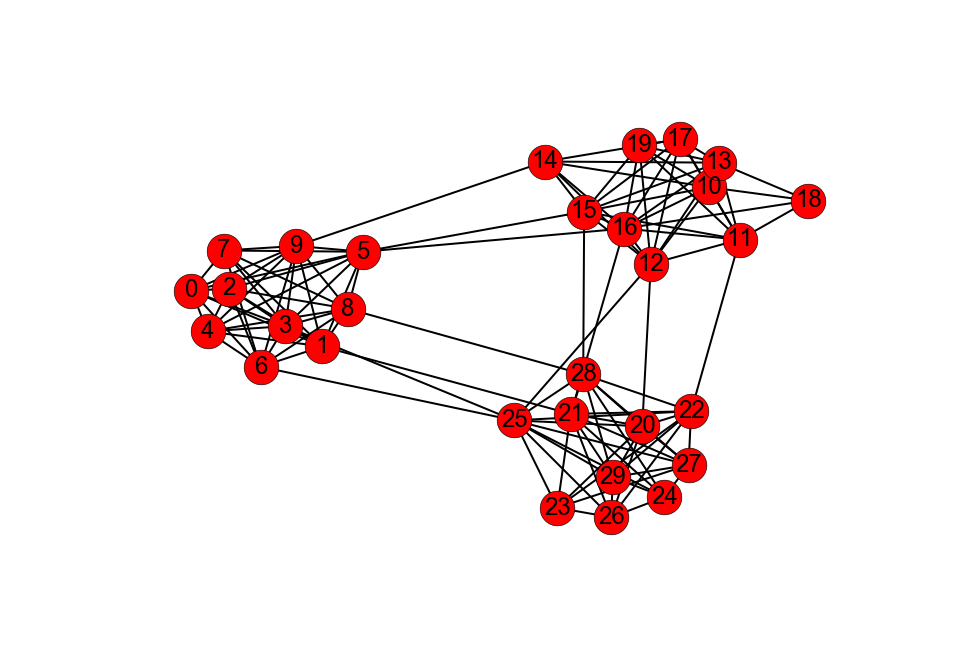

In [160]:
nodes_per_clique = [10, 10, 10]
across_p = 0.05
inside_p = 0.9
cliques = generate_noisy_subcliques(nodes_per_clique, inside_p, across_p)
nx.draw(cliques, with_labels=True)

In [161]:
f = nx.fiedler_vector(cliques)
f

array([-0.27214751, -0.23685013, -0.2679579 , -0.2395842 , -0.2679579 ,
       -0.18762427, -0.24527393, -0.2679579 , -0.23388699, -0.22781198,
        0.20446432,  0.19789204,  0.1696752 ,  0.20446432,  0.13880967,
        0.14560748,  0.15511931,  0.19969394,  0.24325812,  0.20823044,
        0.07570036,  0.04723307,  0.07879017,  0.06845114,  0.05820008,
        0.01953085,  0.06698864,  0.0630638 ,  0.0389958 ,  0.06288396])

In [170]:
s = np.zeros(len(f),dtype='int')
s[f>0]=1
print(s, type(s))

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'>


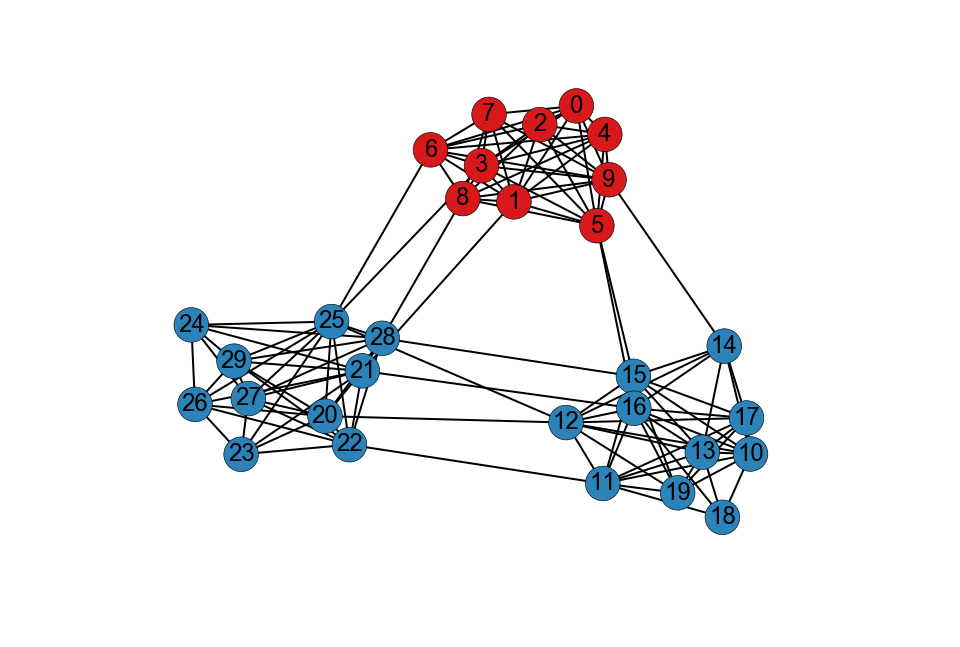

In [227]:
colors = ['#d7191c', '#2b83ba']
node_colors = [colors[s[v]] for v in cliques.nodes()]
nx.draw(cliques, node_color=node_colors, with_labels='True')

## Spectral Clustering

In many cases we would like to move beyond graph partitioning, to allow for clustering into $k$ clusters.

The idea of spectral clustering takes the observations about the Fiedler vector and extends them to more than one dimension.

The basic idea is: 
* use enough of the smallest eigenvectors to properly "spread out" the nodes
* cluster the nodes in the space created by this embedding.

More specifically: Given a graph $G$:

* Compute $L$, the Laplacian of $G$
* Compute the smallest $k$ eigenvectors of $L$, excluding the smallest (the ones vector)
* Let $U \in R^{n\times k}$ be the matrix containing the eigenvectors $w_2, w_3, \dots, w_{k+1}$ as columns
* Let the position of each node $i$ be the point in $R^k$ given by row $i$ of $U$
* Cluster the points into $k$ clusters using $k$-means

In [326]:
L = nx.laplacian_matrix(cliques).todense()
w, v = np.linalg.eig(L)
v = np.array(v)
worder = np.argsort(w)
pos = {i: np.array([f[0], f[1]]) for i, f in enumerate(zip(v[:,worder[1]], v[:,worder[2]]))}

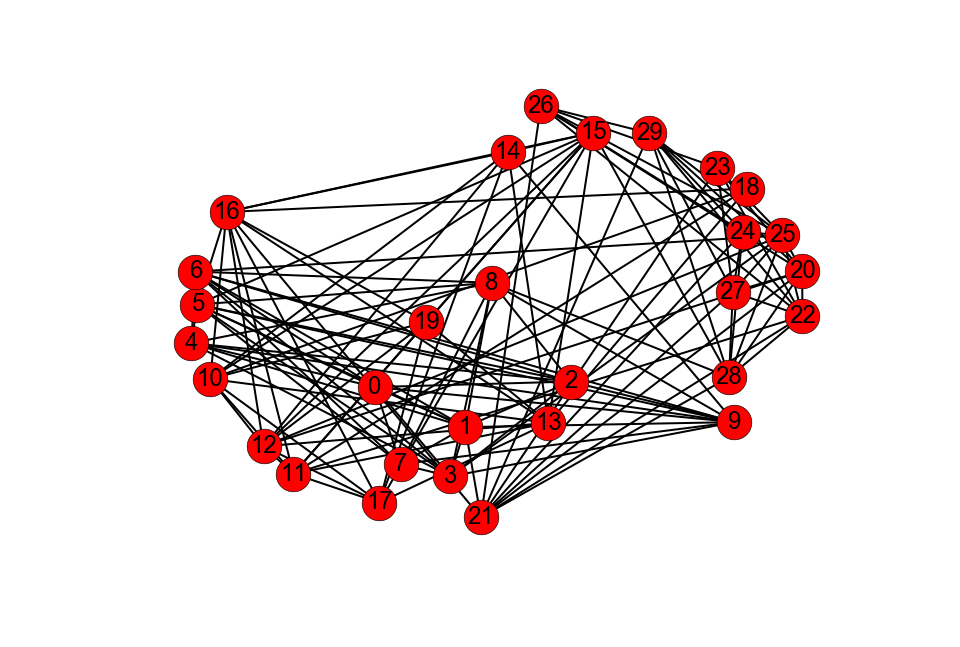

In [363]:
colors = ['#d7191c', '#2b83ba']
node_colors = [colors[s[v]] for v in cliques.nodes()]
nx.draw(cliques, with_labels='True', pos=pos)

In [362]:
print (v.shape, w.shape)
worder = np.argsort(w)
X = v @ np.diag(w)
X = X[:,worder]

(34, 34) (34,)


In [329]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit_predict(X[:,1:3])
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

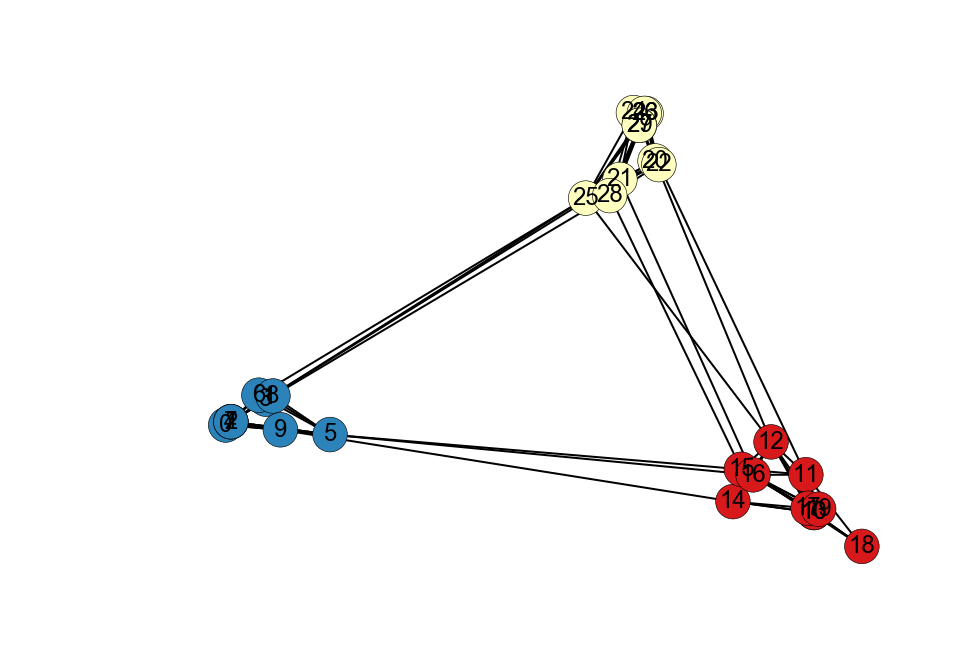

In [330]:
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'black']
node_colors = [colors[labels[v]] for v in cliques]
nx.draw(cliques, node_color=node_colors, with_labels='True', pos=pos)

Let's perform spectral clustering on the karate club:

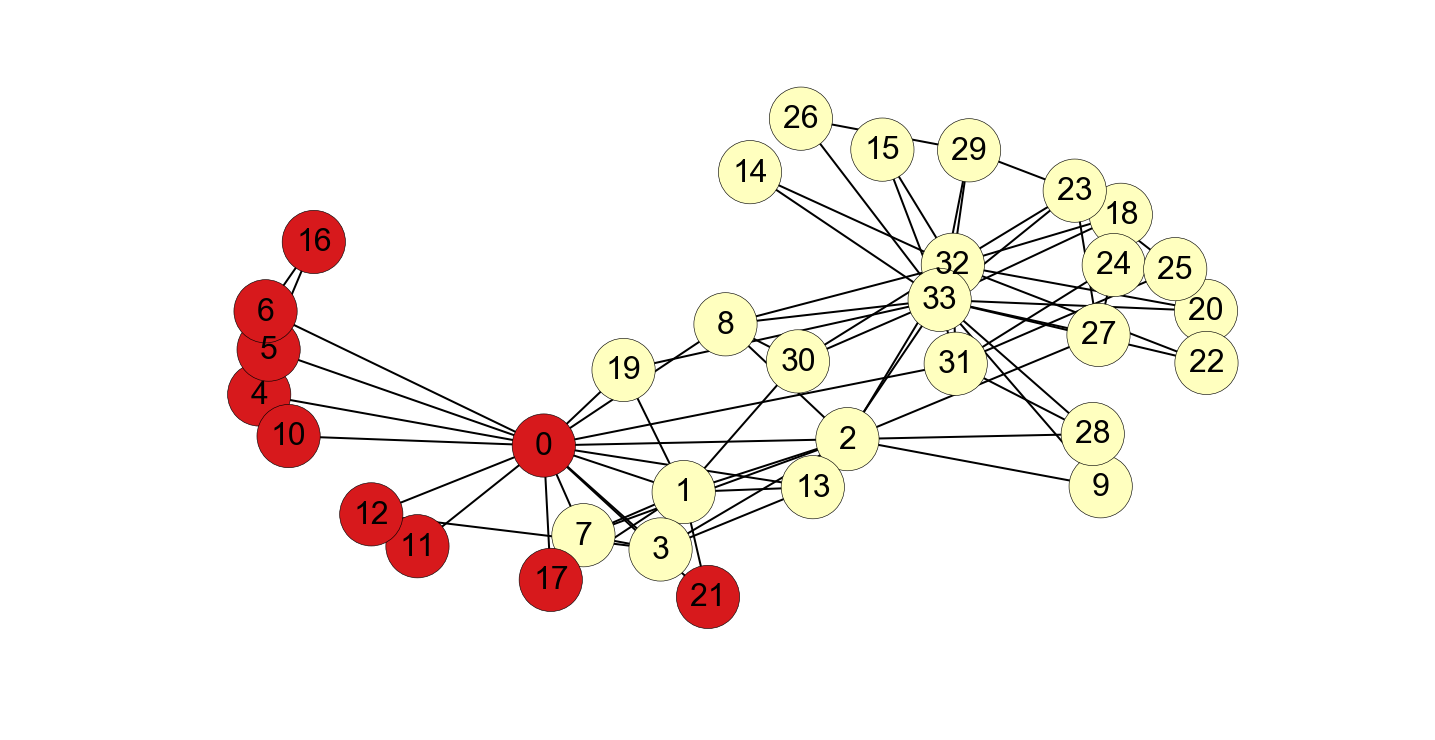

In [361]:
k = 2
G = nx.karate_club_graph()
G = nx.Graph(G)
L = nx.laplacian_matrix(G).todense()
w, v = np.linalg.eig(L)
worder = np.argsort(w)
v = np.array(v)
X = v @ np.diag(w)
X = X[:,worder]
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit_predict(X[:,:k])
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'black', 'green']
node_colors = [colors[labels[v]] for v in G]
np.random.seed(2)
pos = nx.spring_layout(G)
# to understand these results, try plotting what kmeans 'sees'
# pos = {i: np.array([f[0], f[1]]) for i, f in enumerate(zip(v[:,worder[1]], v[:,worder[2]]))}
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
nx.draw(G, node_color=node_colors, with_labels='True', pos=pos, node_size=1000, font_size=16, ax=ax)